# Model 

In [72]:
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, Module, Parameter, ReLU, Sequential, LeakyReLU, Dropout, BatchNorm1d
from torch.nn.functional import cross_entropy
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import wandb
from data_transformer.data_transformer import DataTransformer
from data_analyse.preprocessing import DataPreprocessor
from sklearn.decomposition import PCA
from data_analyse.analyse import DataAnalyzer
import os
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [482]:
class Encoder(Module):
    def __init__(self, data_dim, compress_dims, latent_dim):
        super().__init__()
        dim = data_dim
        seq = []
        for item in list(compress_dims):
            seq += [Linear(dim, item), BatchNorm1d(item), LeakyReLU(), Dropout()]
            dim = item

        self.seq = Sequential(*seq)
        self.fc1 = Linear(dim, latent_dim)
        self.fc2 = Linear(dim, latent_dim)

    def forward(self, input_):
        feature = self.seq(input_)
        mu = self.fc1(feature)
        logvar = self.fc2(feature)
        std = torch.exp(0.5 * logvar)
        return mu, std, logvar


class Decoder(Module):
    def __init__(self, latent_dim, decompress_dims, data_dim):
        super(Decoder, self).__init__()
        dim = latent_dim
        seq = []
        for item in list(decompress_dims):
            seq += [Linear(dim, item),  BatchNorm1d(item), LeakyReLU(), Dropout()]
            dim = item

        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)
        self.sigma = Parameter(torch.ones(data_dim) * 0.1)

    def forward(self, input_):
        return self.seq(input_), self.sigma


def _loss_function(recon_x, x, sigmas, mu, logvar, output_info):
    st = 0
    loss = []
    for column_info in output_info:
        for span_info in column_info:
            if span_info.activation_fn != 'softmax':
                ed = st + span_info.dim
                std = sigmas[st]
                eq = x[:, st] - torch.tanh(recon_x[:, st])
                loss.append((eq**2 / 2 / (std**2)).sum())
                loss.append(torch.log(std) * x.size()[0])
                st = ed

            else:
                ed = st + span_info.dim
                loss.append(
                    cross_entropy(
                        recon_x[:, st:ed], torch.argmax(x[:, st:ed], dim=-1), reduction='sum'
                    )
                )
                st = ed

    assert st == recon_x.size()[1]
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return sum(loss)  / x.size()[0], KLD / x.size()[0]


class TVAE():

    def __init__(
        self,
        latent_dim=128,
        compress_dims=(128, 128),
        decompress_dims=(128, 128),
        l2scale=1e-5,
        batch_size=500,
        epochs=300,
        loss_factor=2,
        cuda=True,
        verbose=False,
        track = False
    ):
        self.latent_dim = latent_dim
        self.compress_dims = compress_dims
        self.decompress_dims = decompress_dims
        self.encoder = None
        self.decoder = None
        self.l2scale = l2scale
        self.batch_size = batch_size
        self.loss_factor = loss_factor
        self.epochs = epochs
        self.verbose = verbose
        self.track = track
        self.transformer = None
        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)
 
    def fit(self, train_data, discrete_columns=(), val_split=0.2, early_stopping_patience=20, early_stopping_delta=0.001, lr = 0.001, patience_beta = None, project = "Data Augmentation - CTVAE"):
        if self.track:
            wandb.init(project=project, name="CTVAE", config={
                "latent_dim": self.latent_dim,
                "compress_dims": self.compress_dims,
                "decompress_dims": self.decompress_dims,
                "l2scale": self.l2scale,
                "batch_size": self.batch_size,
                "epochs": self.epochs,
                "loss_factor": self.loss_factor,
                "val_split": val_split,
                "early_stopping_patience": early_stopping_patience,
                "early_stopping_delta": early_stopping_delta
            })
        self.transformer = DataTransformer()
        self.transformer.fit(train_data, discrete_columns)
        transformed_data = self.transformer.transform(train_data)
        
        data_size = len(transformed_data)
        indices = np.arange(data_size)
        np.random.shuffle(indices)
        
        val_size = int(data_size * val_split)
        train_indices = indices[val_size:]
        val_indices = indices[:val_size]
        
        train_data = transformed_data[train_indices]
        val_data = transformed_data[val_indices]
        
        train_dataset = TensorDataset(torch.from_numpy(train_data.astype('float32')).to(self._device))
        val_dataset = TensorDataset(torch.from_numpy(val_data.astype('float32')).to(self._device))
        
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=False)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False)
        
        data_dim = self.transformer.output_dimensions
        self.encoder = Encoder(data_dim, self.compress_dims, self.latent_dim).to(self._device)
        self.decoder = Decoder(self.latent_dim, self.decompress_dims, data_dim).to(self._device)
        
        optimizer = Adam(
            list(self.encoder.parameters()) + list(self.decoder.parameters()), 
            weight_decay=self.l2scale,
            lr=lr
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min',
            factor=0.5,    
            patience=5,     
            min_lr=1e-6   
        )
        best_val_loss = float('inf')
        early_stopping_counter = 0
        best_model_state = None

        if patience_beta:
            is_des = True
            loss_KL_val = []
            wait_beta = 0
        else:
            is_des = False
        for epoch in range(self.epochs):
            self.encoder.train()
            self.decoder.train()
            train_loss = 0
            train_loss1 = 0 
            train_loss2 = 0  
            batch_count = 0
            loss_KL_train_small = []
            for data in train_loader:
                optimizer.zero_grad()
                real = data[0].to(self._device)
                mu, std, logvar = self.encoder(real)
                eps = torch.randn_like(std)
                emb = eps * std + mu
                rec, sigmas = self.decoder(emb)
                loss_1, loss_2 = _loss_function(
                    rec,
                    real,
                    sigmas,
                    mu,
                    logvar,
                    self.transformer.output_info_list,
                )
                #loss_KL_train_small.append(loss_2)
                loss = loss_1 + loss_2*self.loss_factor
                loss.backward()
                optimizer.step()
                self.decoder.sigma.data.clamp_(0.01, 1.0)
                train_loss += loss.item()
                train_loss1 += loss_1.item()
                train_loss2 += loss_2.item()
                batch_count += 1
            avg_train_loss = train_loss / batch_count
            avg_train_loss1 = train_loss1 / batch_count
            avg_train_loss2 = train_loss2 / batch_count
            
            self.encoder.eval()
            self.decoder.eval()
            val_loss = 0
            val_loss1 = 0
            val_loss2 = 0
            batch_count = 0

                
            with torch.no_grad():
                for data in val_loader:
                    real = data[0].to(self._device)
                    mu, std, logvar = self.encoder(real)
                    eps = torch.randn_like(std)
                    emb = eps * std + mu
                    rec, sigmas = self.decoder(emb)
                    loss_1, loss_2 = _loss_function(
                        rec,
                        real,
                        sigmas,
                        mu,
                        logvar,
                        self.transformer.output_info_list,
                    )
                    loss = loss_1 + loss_2*self.loss_factor
                    val_loss += loss.item()
                    val_loss1 += loss_1.item()
                    val_loss2 += loss_2.item()
                    batch_count += 1
            
            avg_val_loss = val_loss / batch_count
            avg_val_loss1 = val_loss1 / batch_count
            avg_val_loss2 = val_loss2 / batch_count
            
            scheduler.step(avg_val_loss)
            if is_des:
                loss_KL_val.append(avg_train_loss2)
                if len(loss_KL_val) > 1:
                    if loss_KL_val[-1] > loss_KL_val[-2]:
                        if wait_beta >= patience_beta:
                            self.loss_factor = self.loss_factor*2
                            wait_beta = 0
                        else:
                            wait_beta += 1

            current_lr = optimizer.param_groups[0]['lr']
            if self.track :
                wandb.log({
                    "epoch": epoch,
                    "train_loss": avg_train_loss,
                    "train_reconstruction_loss": avg_train_loss1,
                    "train_kl_divergence_loss": avg_train_loss2,
                    "val_loss": avg_val_loss,
                    "val_reconstruction_loss": avg_val_loss1,
                    "val_kl_divergence_loss": avg_val_loss2,
                    "learning_rate": current_lr
                })
            if self.verbose :
                if epoch % 5 == 0 or epoch == self.epochs - 1:
                    print(f"Epoch {epoch}/{self.epochs} - "
                          f"Train Loss: {avg_train_loss:.4f} (Rec: {avg_train_loss1:.4f}, KL: {avg_train_loss2:.4f}), "
                          f"Val Loss: {avg_val_loss:.4f} (Rec: {avg_val_loss1:.4f}, KL: {avg_val_loss2:.4f}), "
                          f"LR: {current_lr:.6f}, "
                          f"Patient: {early_stopping_counter}/{early_stopping_patience} ")
            if avg_val_loss < best_val_loss - early_stopping_delta:
                best_val_loss = avg_val_loss
                early_stopping_counter = 0
                
                best_model_state = {
                    'encoder': self.encoder.state_dict(),
                    'decoder': self.decoder.state_dict(),
                    'epoch': epoch,
                    'val_loss': avg_val_loss
                }
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= early_stopping_patience:
                    print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.4f}")
                    if self.track:
                        wandb.log({"early_stopping": epoch})
                    if best_model_state:
                        self.encoder.load_state_dict(best_model_state['encoder'])
                        self.decoder.load_state_dict(best_model_state['decoder'])
                    
                    break

        if early_stopping_counter < early_stopping_patience and best_model_state:
            self.encoder.load_state_dict(best_model_state['encoder'])
            self.decoder.load_state_dict(best_model_state['decoder'])
        if self.track:
            wandb.finish()
            
    def sample(self, samples):
        self.decoder.eval()

        steps = samples // self.batch_size + 1
        data = []
        for _ in range(steps):
            mean = torch.zeros(self.batch_size, self.latent_dim)
            std = mean + 1
            noise = torch.normal(mean=mean, std=std).to(self._device)
            fake, sigmas = self.decoder(noise)
            fake = torch.tanh(fake)
            data.append(fake.detach().cpu().numpy())
        data = np.concatenate(data, axis=0)
        data = data[:samples]
        return self.transformer.inverse_transform(data, sigmas.detach().cpu().numpy())

    def set_device(self, device):
        """Set the `device` to be used ('GPU' or 'CPU)."""
        self._device = device
        self.decoder.to(self._device)
        
    def save(self):
        if self.encoder is None or self.decoder is None:
            raise RuntimeError("Model not trained. Call fit() first.")
        is_saved = False
        file_name = input("Tap model's name:" )
        while not is_saved:
            if os.path.exists(f"models/{file_name}.pth"):
                print("Model's name existes!!!!")
                file_name = input("Tap model's name:" )
            else:
                torch.save(self,f"models/{file_name}.pth")
                is_saved = True
                print("Done!!!!")
        return 1
    def load(self, file_name):
        model = torch.load(f"models/{file_name}.pth", map_location=self._device, weights_only=False)
        self.encoder = model.encoder
        self.decoder = model.decoder
        self.latent_dim = model.latent_dim
        self.compress_dims = model.compress_dims
        self.decompress_dims = model.decompress_dims
        self.transformer = model.transformer

        

# Preprocessing

In [674]:
data = pd.read_csv('data/DataModified.csv', sep=',')
cat_cols = ["CONFIG", "T", "EQUIPEMENT", "FREQUENCE"]
num_cols = ["DATA", "DELTA", "MESURE A", "MESURE A REF", "MESURE B"] 
param_cols = cat_cols +num_cols
preprocessor = DataPreprocessor(
        categorical_cols=cat_cols,
        numerical_cols=num_cols)
cleaned_data, cleaned_output = preprocessor.preprocess(data, cut  = False)

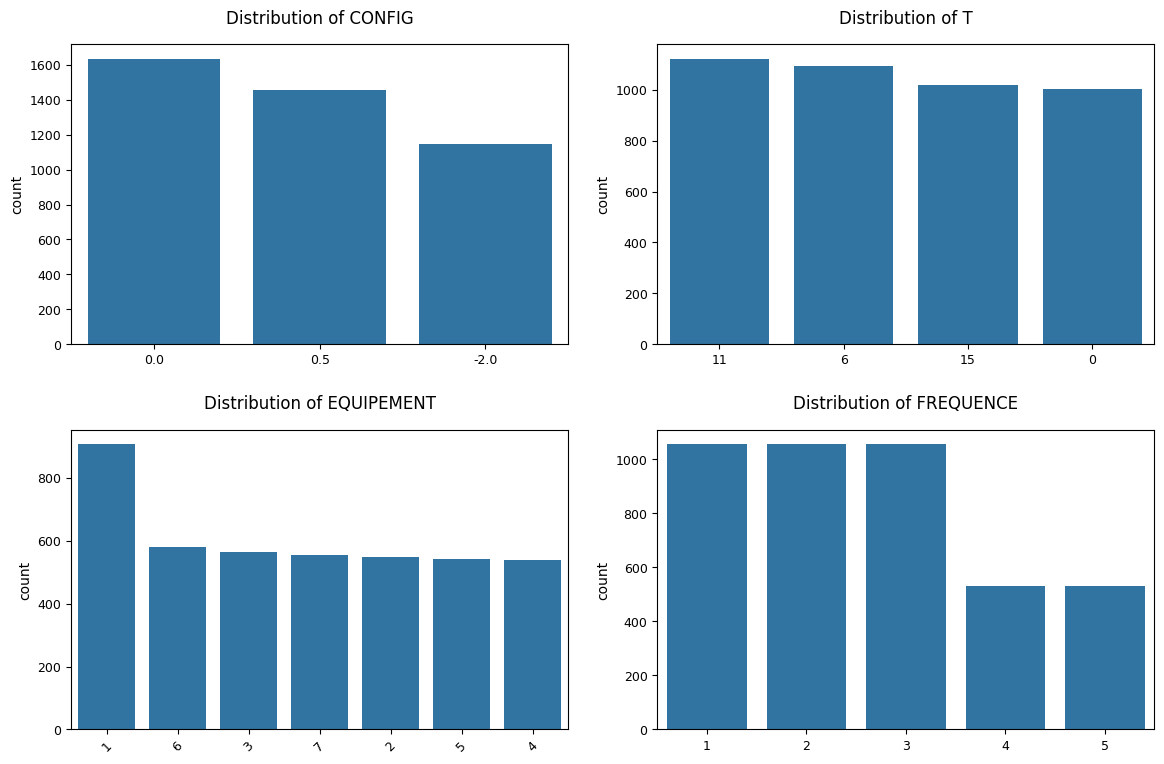

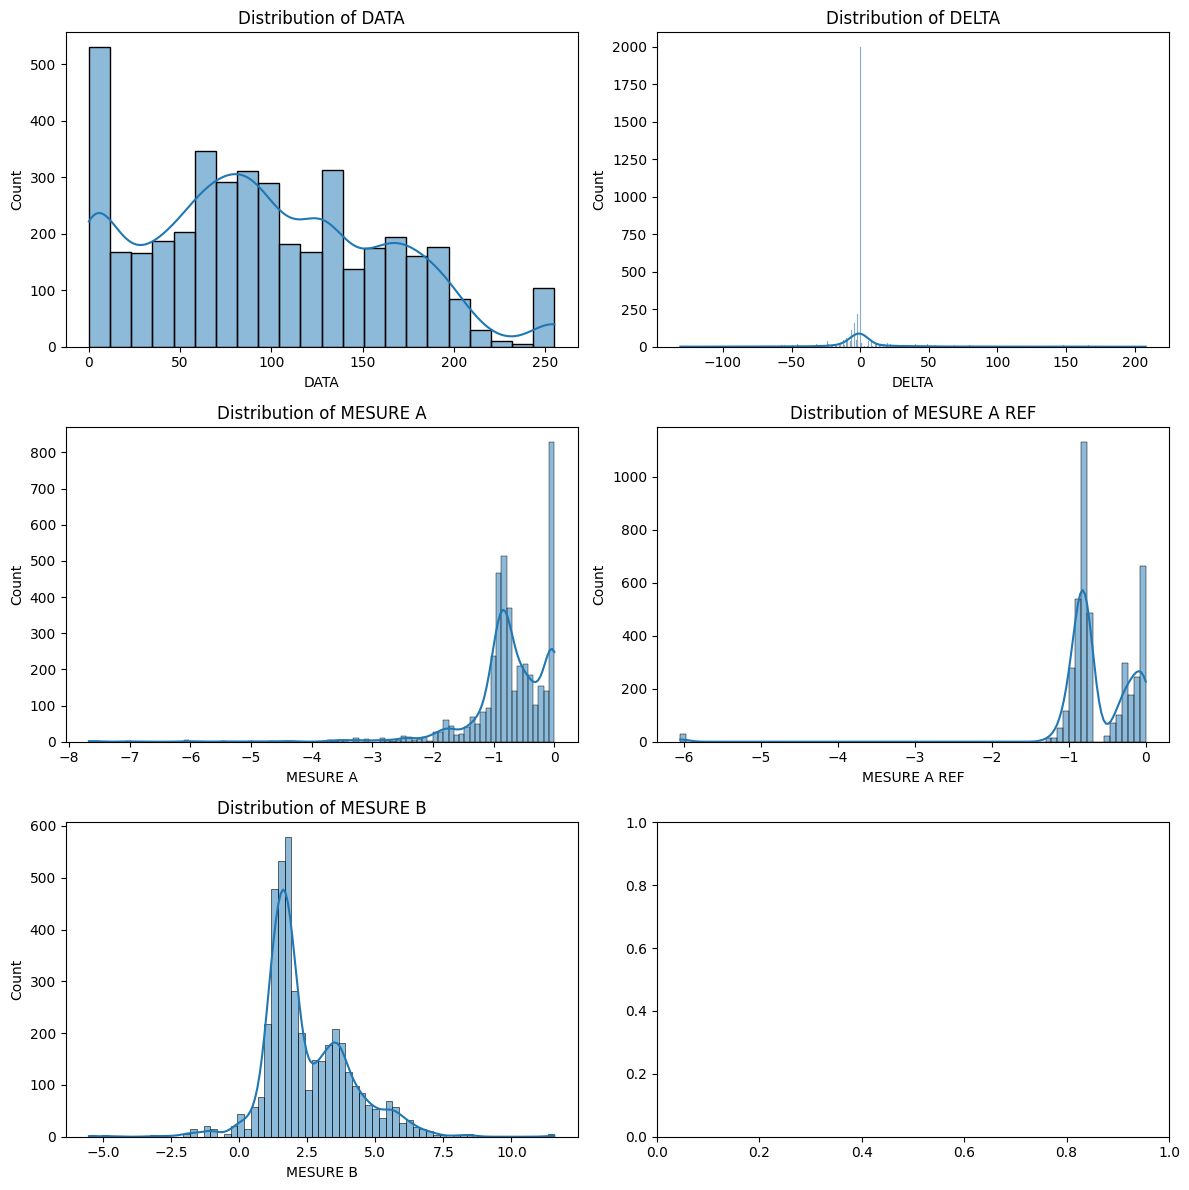

In [412]:
analyzer = DataAnalyzer(cleaned_data, numeric_columns = num_cols, categorical_columns= cat_cols)
cat_plot = analyzer.plot_distributions_cat()
num_plot = analyzer.plot_distributions()

# Train using PCA

In [676]:
trainable_data_pca, pca = preprocessor.apply_pca(cleaned_data, cleaned_output, n_components= 23)

Information kept: 99.999279488%


In [682]:
tvae_pca = TVAE(compress_dims= (512,256), decompress_dims= (256,512),latent_dim=256,track= True, verbose= True, loss_factor= 0.1,batch_size=300, epochs= 1000)
tvae_pca.fit(train_data= trainable_data_pca, discrete_columns= param_cols, lr= 0.01, project="TVAE_PCA")

Epoch 0/1000 - Train Loss: 324.5851 (Rec: 282.0903, KL: 424.9480), Val Loss: 255.1374 (Rec: 242.3063, KL: 128.3107), LR: 0.010000, Patient: 0/20 
Epoch 5/1000 - Train Loss: 72.4527 (Rec: 66.5041, KL: 59.4861), Val Loss: 58.9036 (Rec: 57.3832, KL: 15.2042), LR: 0.010000, Patient: 0/20 
Epoch 10/1000 - Train Loss: 68.1236 (Rec: 63.5171, KL: 46.0645), Val Loss: 57.0025 (Rec: 55.6175, KL: 13.8499), LR: 0.010000, Patient: 0/20 
Epoch 15/1000 - Train Loss: 62.1710 (Rec: 59.3806, KL: 27.9038), Val Loss: 54.5218 (Rec: 53.6797, KL: 8.4213), LR: 0.010000, Patient: 1/20 
Epoch 20/1000 - Train Loss: 58.2333 (Rec: 56.0971, KL: 21.3628), Val Loss: 53.8164 (Rec: 53.0681, KL: 7.4832), LR: 0.010000, Patient: 0/20 
Epoch 25/1000 - Train Loss: 54.1091 (Rec: 52.4551, KL: 16.5397), Val Loss: 52.8144 (Rec: 51.9570, KL: 8.5736), LR: 0.010000, Patient: 1/20 
Epoch 30/1000 - Train Loss: 51.7287 (Rec: 50.3379, KL: 13.9082), Val Loss: 51.2809 (Rec: 50.4268, KL: 8.5407), LR: 0.010000, Patient: 0/20 
Epoch 35/1000

early_stopping,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
learning_rate,███████████████████████▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁
train_kl_divergence_loss,█▃▁▂▂▂▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_reconstruction_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_kl_divergence_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reconstruction_loss,███▇▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
early_stopping,434
epoch,434


In [585]:
ctvae.save()

Tap model's name: ctvae1


Model's name existes!!!!


Tap model's name: ctvae2


Model's name existes!!!!


Tap model's name: ctvae3


Model's name existes!!!!


Tap model's name: ctvae1


Done!!!!


1

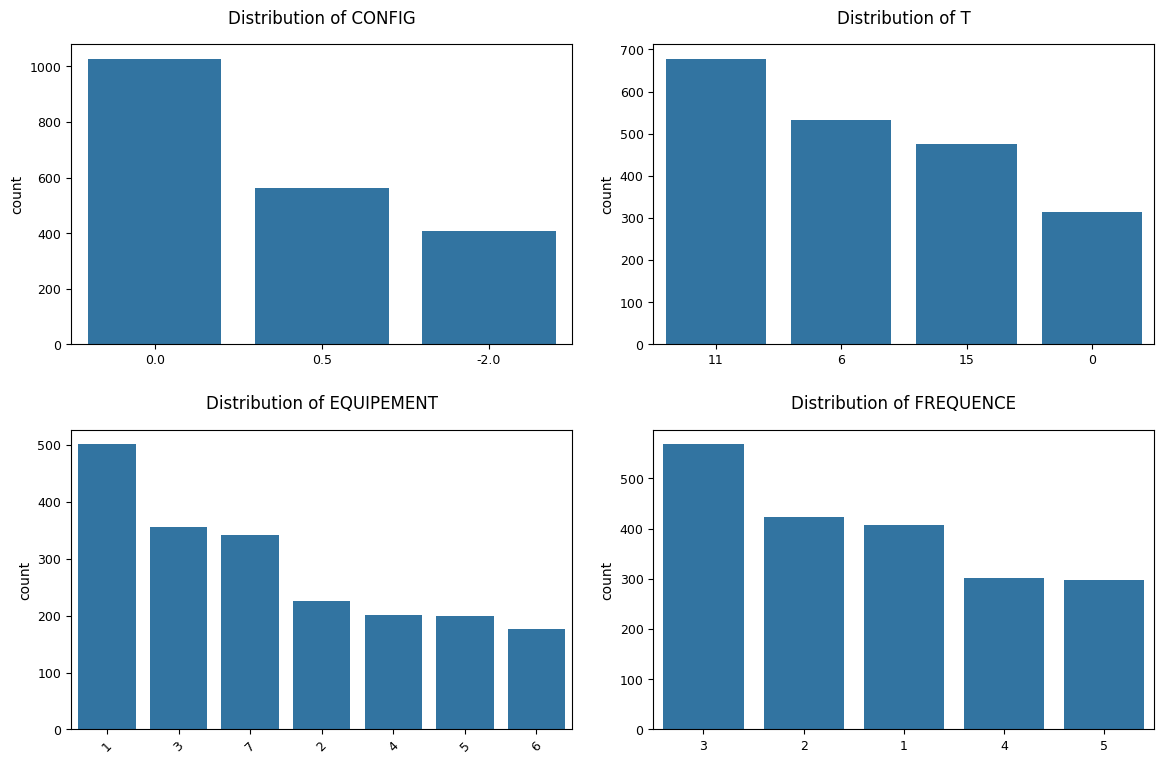

In [684]:
n = 2000
synthetic_data = tvae_pca.sample(n)
output = pd.DataFrame(synthetic_data.iloc[:,9:])
output_inverse = pca.inverse_transform([synthetic_data.iloc[:,9:]])
output_inverse = pd.DataFrame(output_inverse[0], columns=[f'OUTPUT_{i}' for i in range(101 - output_inverse.shape[2], 101)])
synthetic_data = pd.concat([synthetic_data.iloc[:,:9], output_inverse], axis=1)

analyzer_pca = DataAnalyzer(synthetic_data, numeric_columns = num_cols, categorical_columns= cat_cols)
cat_plot_pca = analyzer_pca.plot_distributions_cat()

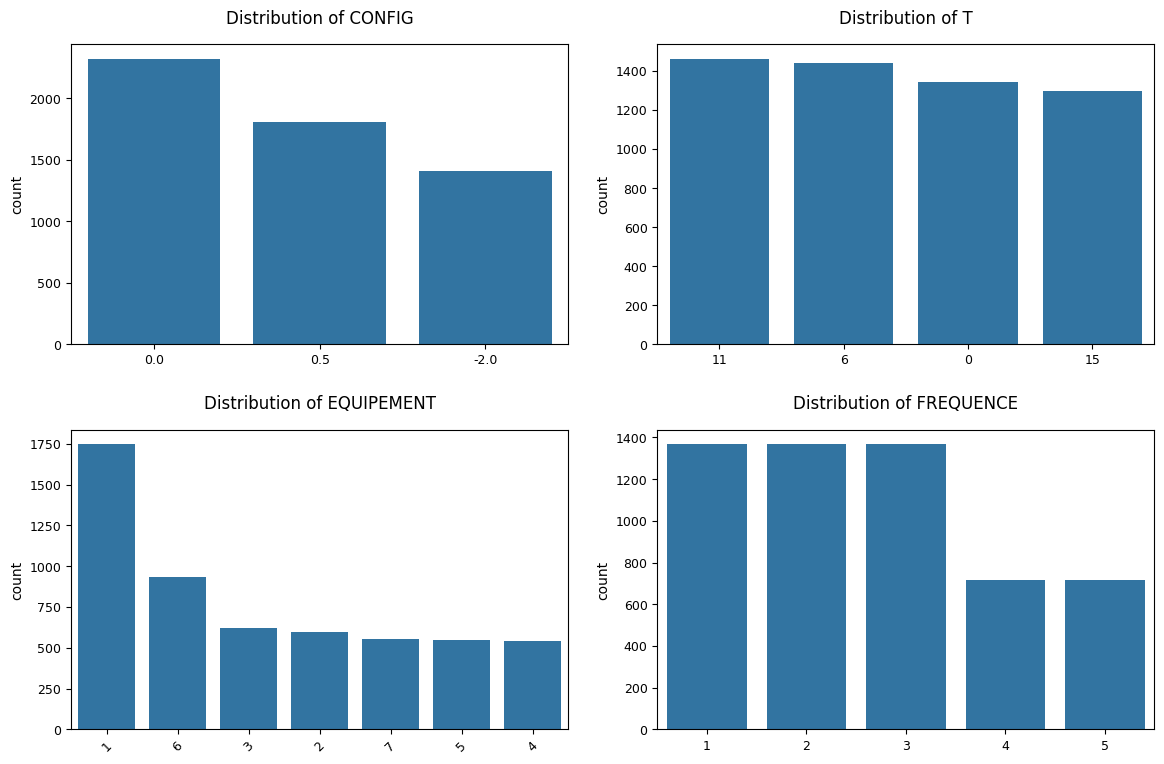

In [27]:
cat_plot

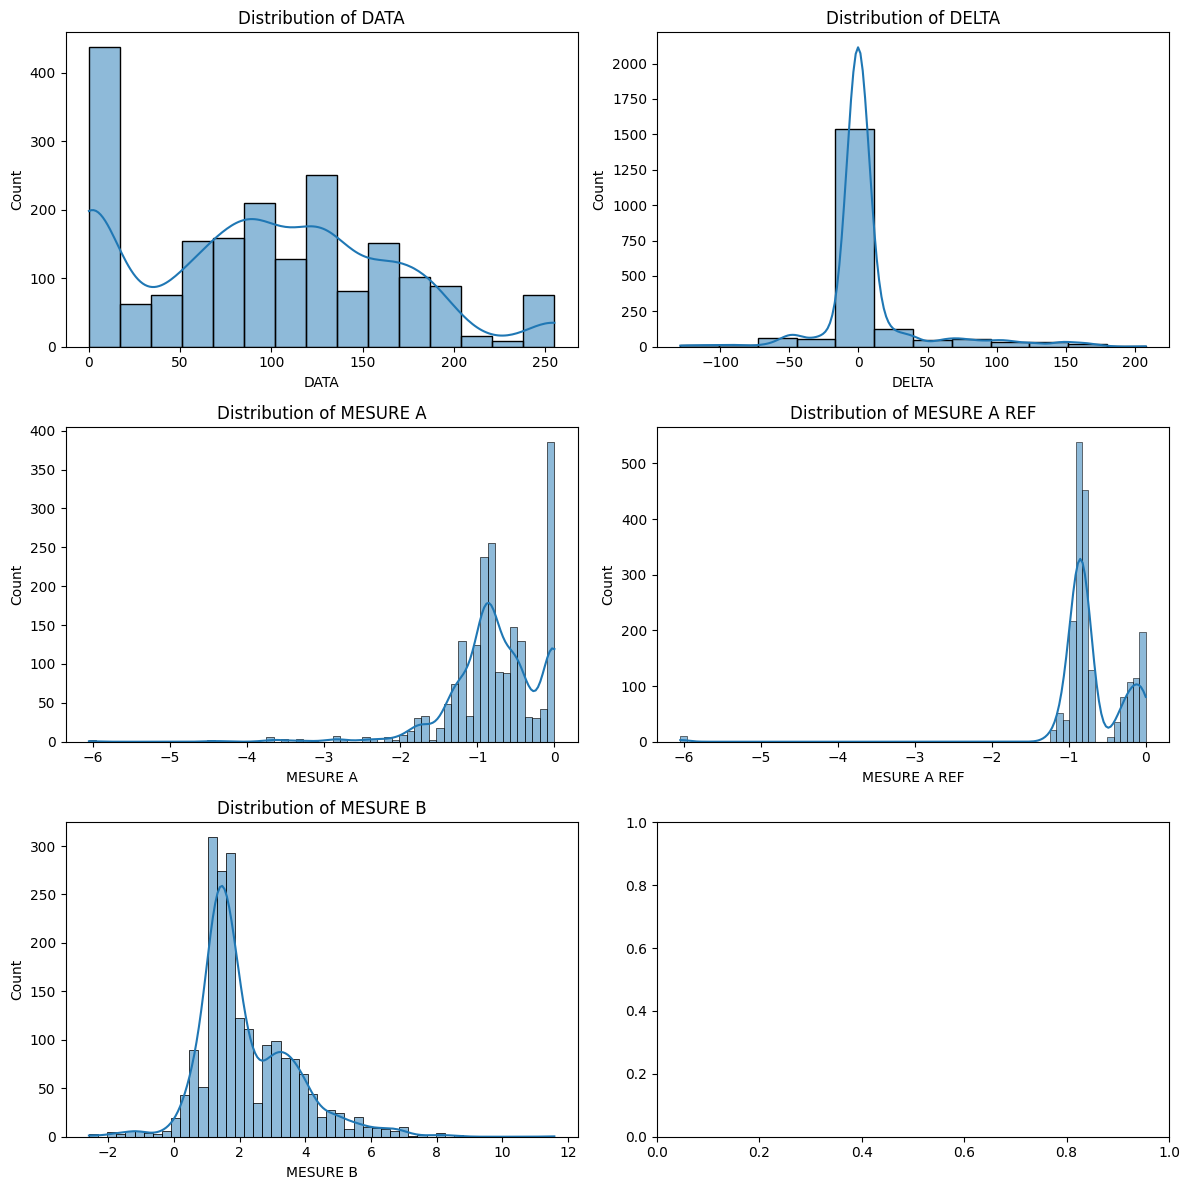

In [686]:
dis_plot_pca = analyzer_pca.plot_distributions()

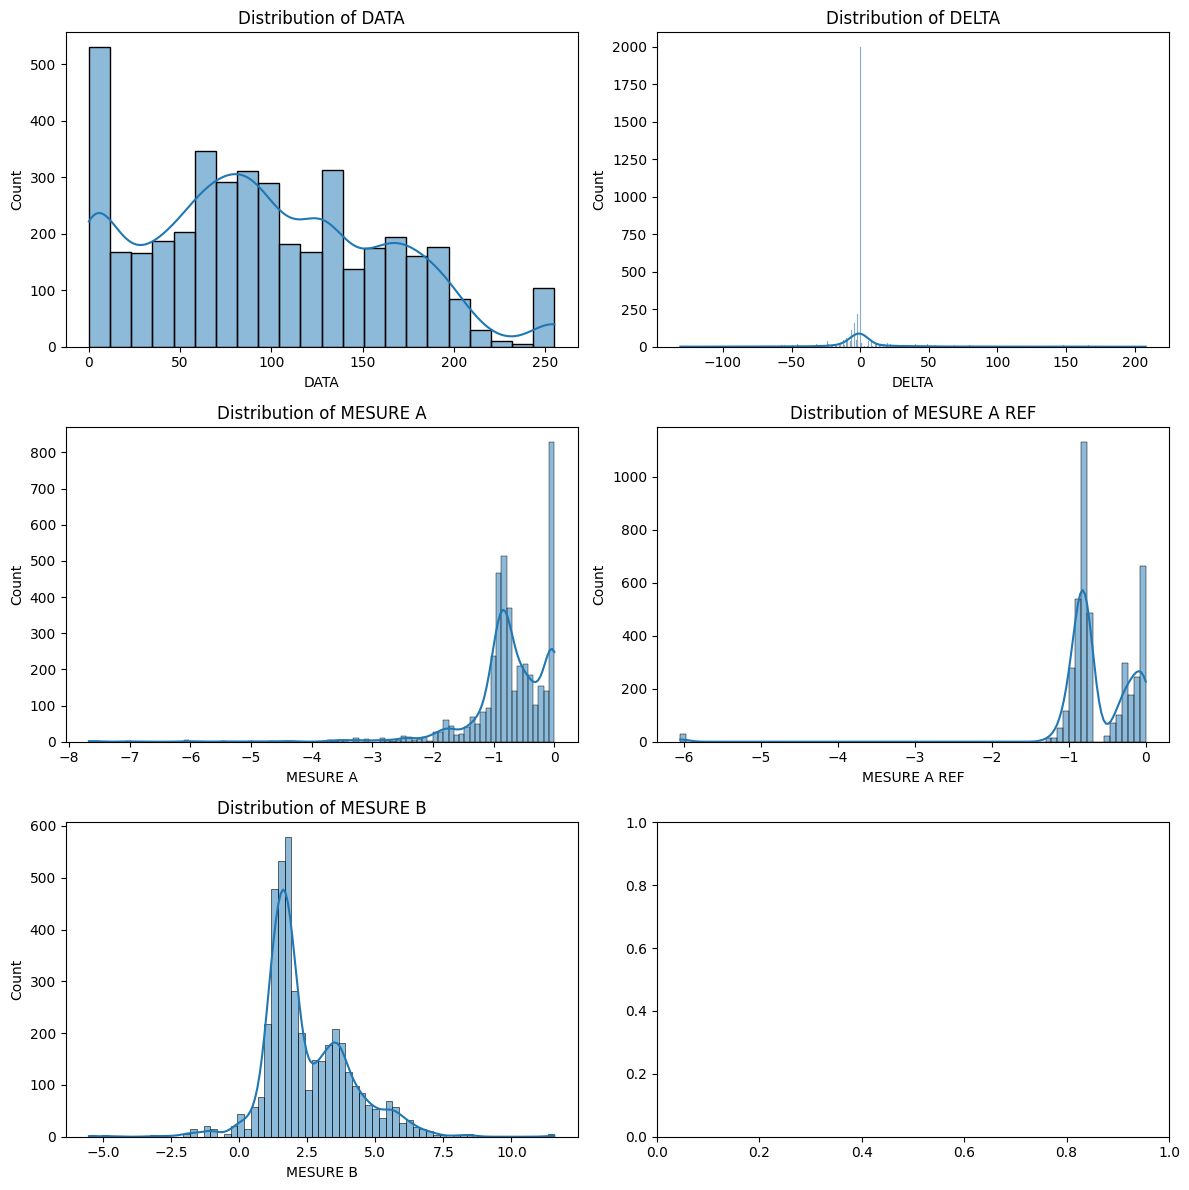

In [54]:
num_plot

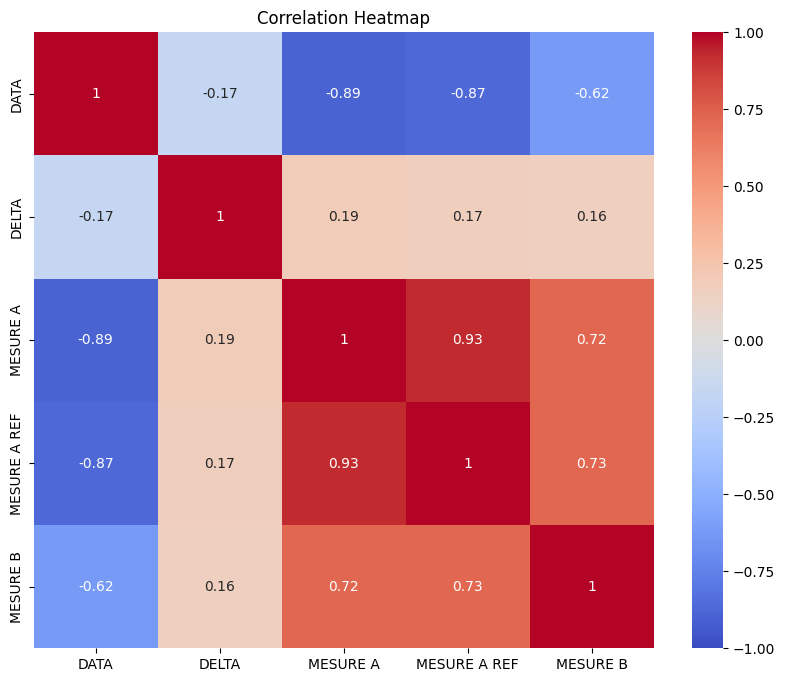

In [424]:
heat_map = analyzer_pca.plot_correlation_heatmap()

In [698]:
synthetic_data.describe()

,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,OUTPUT_0,...,OUTPUT_91,OUTPUT_92,OUTPUT_93,OUTPUT_94,OUTPUT_95,OUTPUT_96,OUTPUT_97,OUTPUT_98,OUTPUT_99,OUTPUT_100
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,94.326500,-0.267000,8.890500,3.630500,6.951000,-0.754760,-0.697608,2.184783,2.830000,37.989536,...,98.095471,98.104617,98.110997,98.111465,98.110565,98.106892,98.102811,98.097353,98.092614,98.087046
std,69.182816,0.903116,5.002202,2.177232,36.324969,0.607745,0.506444,1.452661,1.320974,1.160895,...,2.226431,2.259334,2.285328,2.305210,2.318560,2.329159,2.335860,2.341204,2.343806,2.346167
min,0.000000,-2.000000,0.000000,1.000000,-129.000000,-6.049308,-6.049308,-2.584518,1.000000,33.505525,...,90.185284,90.175812,90.190861,90.207908,90.245296,90.268107,90.296725,90.285387,90.267008,90.245326
25%,34.000000,0.000000,6.000000,1.000000,0.000000,-0.990128,-0.886850,1.267100,2.000000,37.208263,...,96.973555,96.956609,96.951067,96.935138,96.936135,96.917957,96.918449,96.918251,96.925773,96.910689
50%,94.000000,0.000000,11.000000,3.000000,0.000000,-0.792537,-0.811410,1.749723,3.000000,37.945651,...,98.315141,98.323397,98.300922,98.273323,98.264126,98.254050,98.240907,98.224430,98.220390,98.204901
75%,142.000000,0.500000,11.000000,6.000000,0.000000,-0.385148,-0.362008,3.051033,4.000000,38.695579,...,99.573614,99.568642,99.561948,99.550878,99.547400,99.541533,99.539705,99.539212,99.537763,99.553097
max,255.000000,0.500000,15.000000,7.000000,208.000000,0.000000,0.000000,11.580734,5.000000,44.213378,...,103.785224,104.074897,104.318971,104.527788,104.692076,104.834827,104.946180,105.039164,105.109921,105.167723


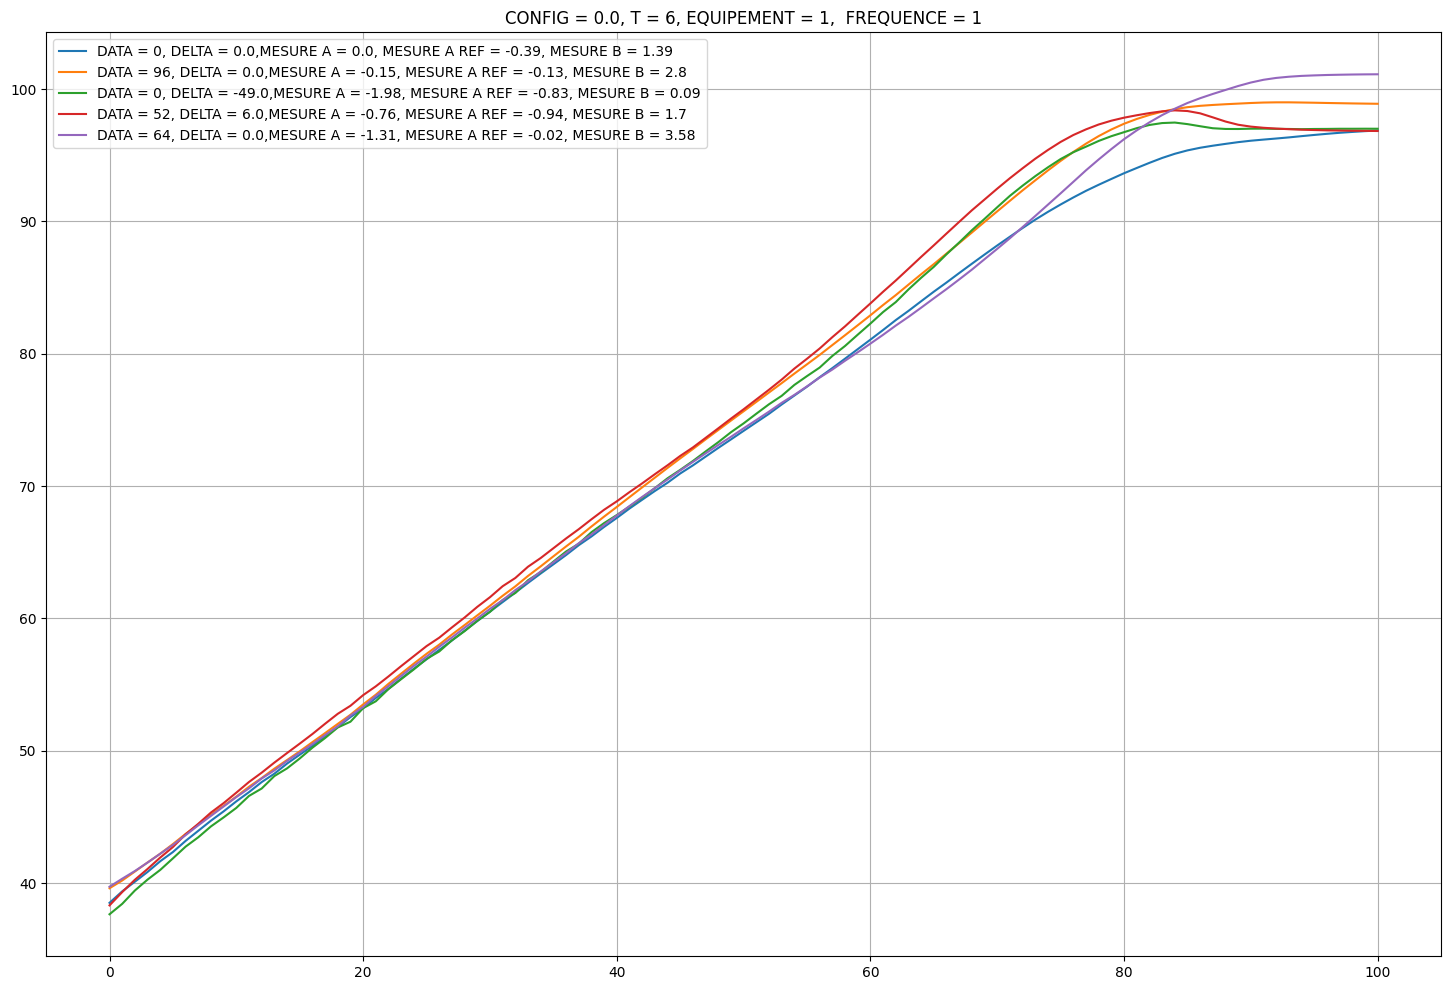

In [700]:
analyzer_pca.plot_syn_data({
    "CONFIG" : 0,
    "T": 6,
    "EQUIPEMENT" : 1,
    "FREQUENCE" : 1
}, noutput=20)

C:\Users\anhqu\Desktop\Anh Quan\Data Augmentation\Code\data_analyse\analyse.py:161: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


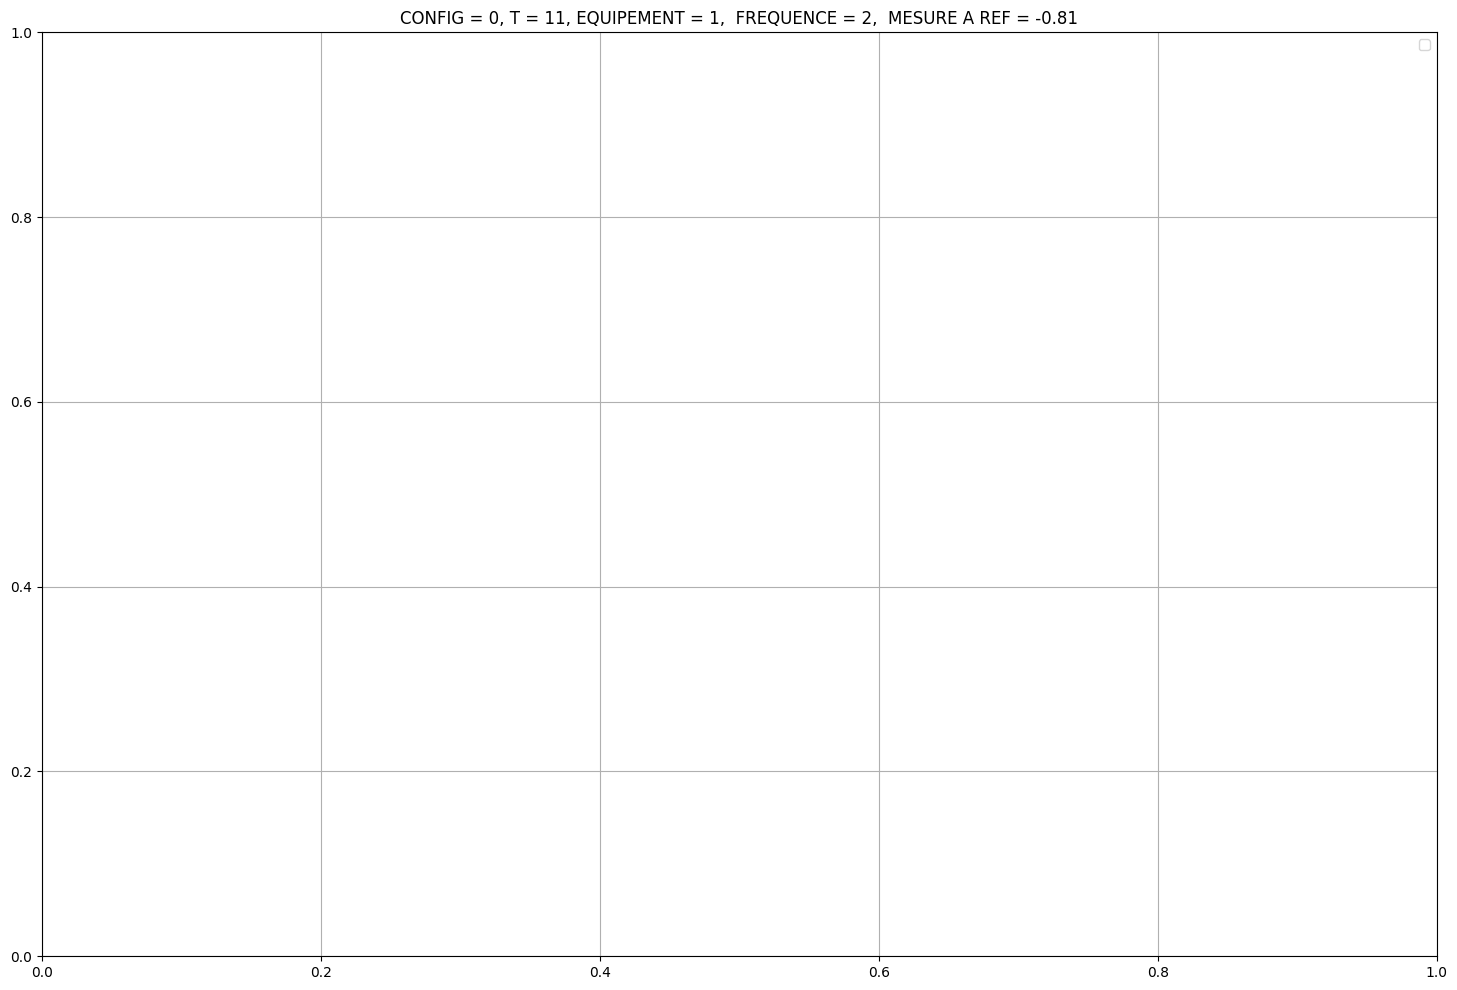

In [694]:
analyzer_pca.plot_syn_data_plus({
    "CONFIG" : 0,
    "T": 11,
    "EQUIPEMENT" : 1,
    "FREQUENCE" : 2,
    "MESURE A REF" : -0.81
}, noutput=10)

In [624]:
cleaned_data["MESURE A REF"]

0      -0.980103
1      -0.980103
2      -0.980103
3      -0.980103
4      -0.980103
          ...   
4230   -1.093460
4231   -1.093460
4232   -0.717651
4233   -0.717651
4234   -0.717651
Name: MESURE A REF, Length: 4235, dtype: float64

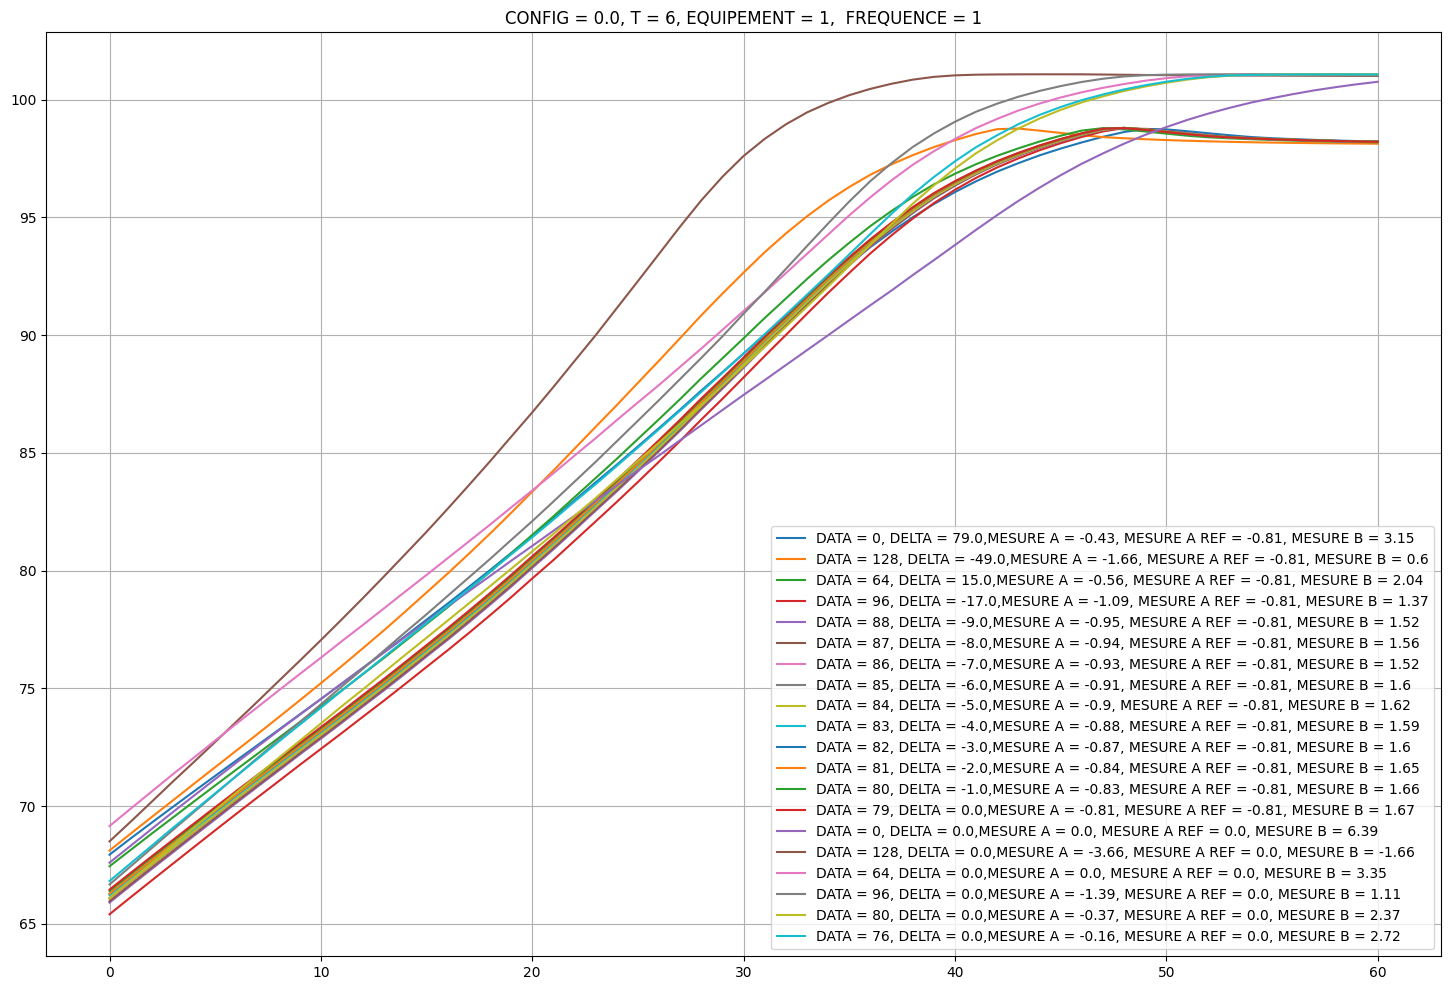

In [672]:
analyzer.plot_syn_data({
    "CONFIG" : 0,
    "T": 6,
    "EQUIPEMENT" : 1,
    "FREQUENCE" : 1
}, noutput=20)

# Train using TWD

In [262]:
trainable_data_ondelette = preprocessor.apply_wavelet_transform(cleaned_data = cleaned_data,cleaned_output =  cleaned_output, wavelet = 'db4', level = 2, threshold= 0.01)

In [264]:
tvae_twd = TVAE(compress_dims= (64,32,24,16), decompress_dims= (16,24,32,64),latent_dim=16,track= True, verbose= True, loss_factor= 0.1,batch_size=300)
tvae_twd.fit(train_data= trainable_data_ondelette, discrete_columns= cat_cols, lr= 0.01, project="TVAE_TWD")

Epoch 0/300 - Train Loss: 261.4866 (Rec: 187.4690, KL: 740.1762), Val Loss: -1.5678 (Rec: -1.5980, KL: 0.3017), LR: 0.010000, Patient: 0/20 
Epoch 5/300 - Train Loss: -19.4067 (Rec: -19.9063, KL: 4.9955), Val Loss: -25.1370 (Rec: -25.2047, KL: 0.6776), LR: 0.010000, Patient: 0/20 
Epoch 10/300 - Train Loss: -26.5650 (Rec: -26.9547, KL: 3.8974), Val Loss: -30.9466 (Rec: -31.0059, KL: 0.5930), LR: 0.010000, Patient: 0/20 
Epoch 15/300 - Train Loss: -27.5890 (Rec: -27.9619, KL: 3.7291), Val Loss: -31.4407 (Rec: -31.4953, KL: 0.5459), LR: 0.010000, Patient: 2/20 
Epoch 20/300 - Train Loss: -26.4786 (Rec: -26.8310, KL: 3.5239), Val Loss: -31.3628 (Rec: -31.4272, KL: 0.6447), LR: 0.010000, Patient: 0/20 
Epoch 25/300 - Train Loss: -28.6013 (Rec: -28.9270, KL: 3.2570), Val Loss: -31.7831 (Rec: -31.8740, KL: 0.9090), LR: 0.010000, Patient: 5/20 
Epoch 30/300 - Train Loss: -28.9634 (Rec: -29.2894, KL: 3.2596), Val Loss: -32.2284 (Rec: -32.3344, KL: 1.0602), LR: 0.010000, Patient: 2/20 
Epoch 35

early_stopping,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
learning_rate,█████████████████▄▄▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_kl_divergence_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▇▆▅▄▄▃▄▃▃▃▃▃▂▃▃▂▂▃▂▂▂▂▂▂▃▂▂▂▁▁▂▁▂▂▂▁▁
train_reconstruction_loss,█▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_kl_divergence_loss,▁▂▂▂▂▂▂▃▆▆▇▇▇▆▇▇██▇█▇▇▇▇▆▇▆▇▆▆▆▆▆▆▆▆▆▆▆▆
val_loss,█▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reconstruction_loss,█▇▆▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
early_stopping,265
epoch,265


In [266]:
n = 1000
synthetic_data = tvae_twd.sample(n)

In [268]:
output_inverse = preprocessor.inverse_wavelet_transform(df_all_coeffs = synthetic_data.iloc[:,9:], original_shape = (n, cleaned_output.shape[1]), wavelet='db4', level = 3, threshold= 0.01)

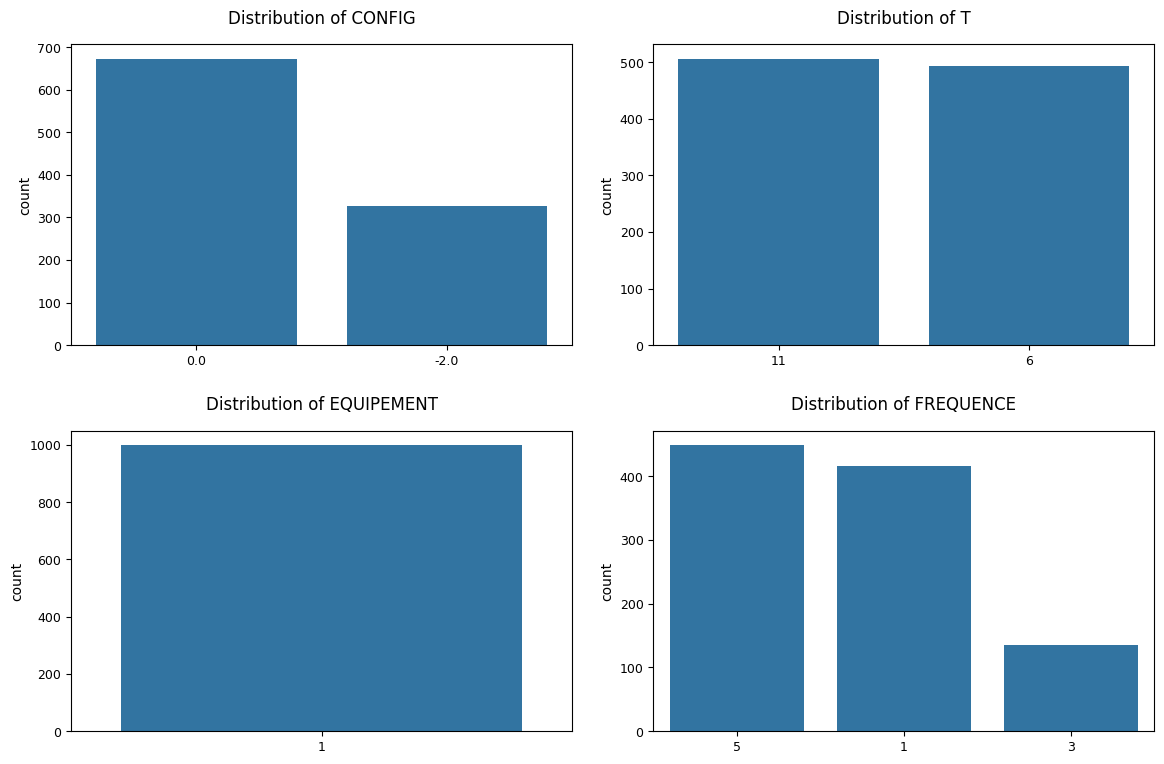

In [270]:
synthetic_data = pd.concat([synthetic_data.iloc[:,:9], output_inverse], axis=1)

analyzer = DataAnalyzer(synthetic_data, numeric_columns = num_cols, categorical_columns= cat_cols)
cat_plot = analyzer.plot_distributions_cat()

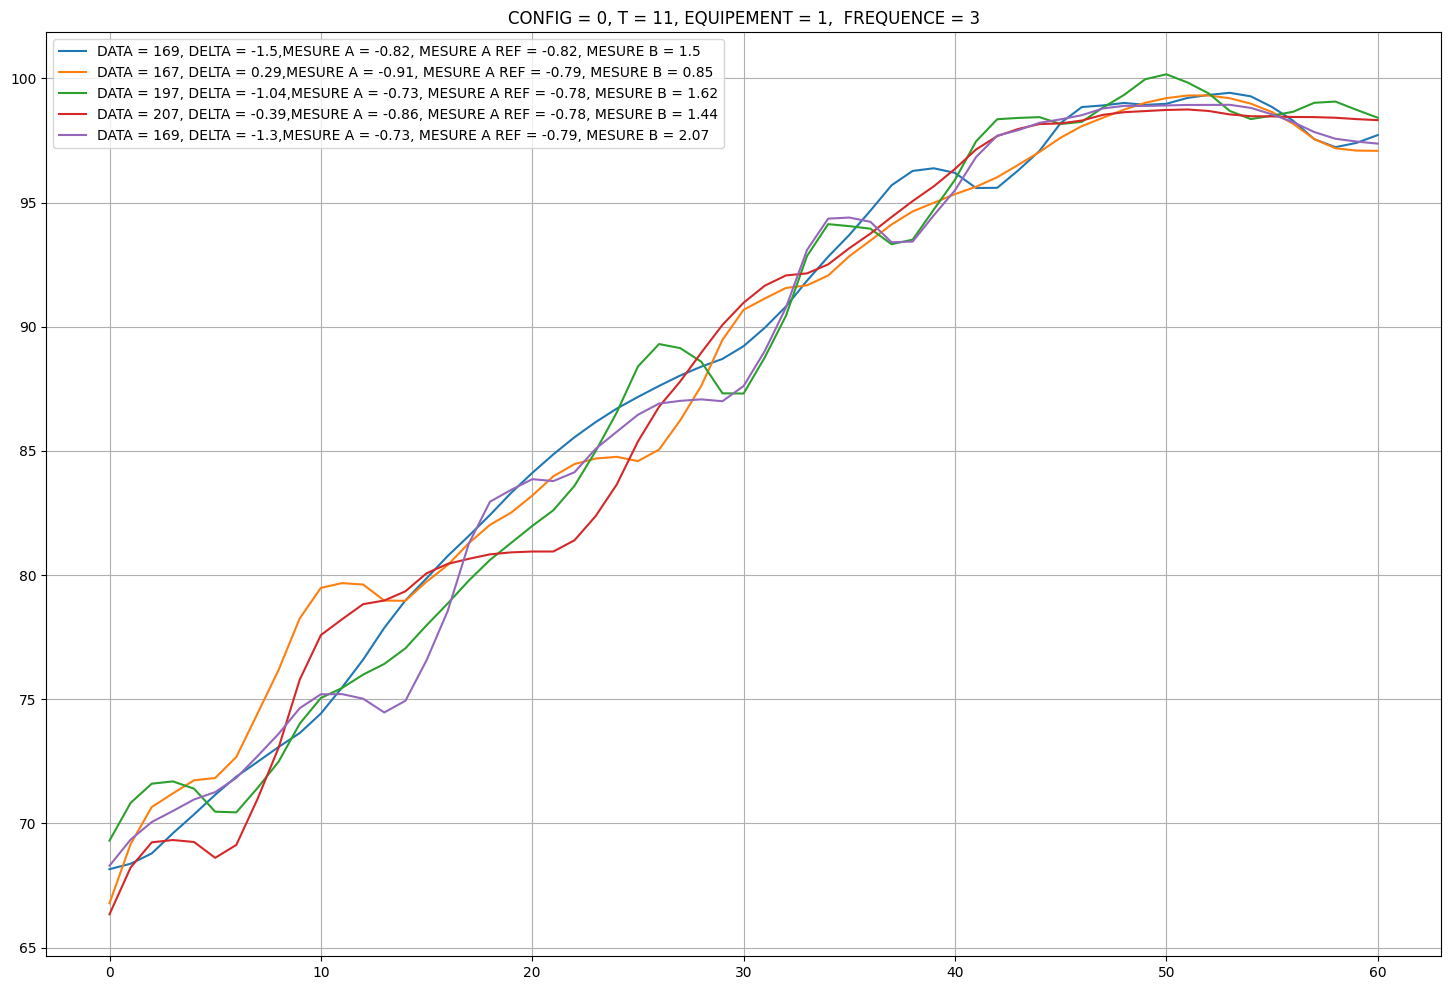

In [276]:
analyzer.plot_syn_data({
    "CONFIG" : 0,
    "T": 11,
    "EQUIPEMENT" : 1,
    "FREQUENCE" : 3
})

In [182]:
synthetic_data

,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,approx_0,...,detail_3_44,detail_3_45,detail_3_46,detail_3_47,detail_3_48,detail_3_49,detail_3_50,detail_3_51,detail_3_52,detail_3_53
0,195,0.0,6,1,0.597175,-0.929431,-0.776862,1.697098,4,111.079478,...,0.000731,0.000055,0.000149,0.000194,0.000247,2.510078e-04,-0.000426,0.000751,-0.000135,-0.000362
1,208,0.0,6,1,-1.681806,-0.840857,-0.854541,1.628375,4,109.524317,...,0.000968,0.000608,0.000081,-0.000417,-0.000263,4.826278e-07,0.000099,0.000499,0.000464,-0.000104
2,76,-2.0,11,1,0.722759,0.031245,0.002159,2.884129,3,114.274163,...,0.001026,-0.000775,-0.000415,-0.000277,0.000274,9.610365e-05,0.000042,-0.000266,0.000216,-0.000149
3,33,0.0,11,1,-0.168661,-0.628000,-0.042736,2.923797,3,114.238105,...,-0.000166,-0.000521,0.000305,0.000488,-0.000292,1.034167e-04,0.000292,-0.000003,0.000063,-0.000458
4,143,0.0,6,1,-0.725387,-0.799826,-0.724249,1.868957,4,109.926029,...,-0.001156,-0.000242,0.000075,0.000131,-0.000372,-1.020992e-04,0.000372,-0.000360,-0.000073,0.000105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,206,0.0,6,1,-0.298412,-0.784472,-0.723884,1.828133,3,111.262729,...,0.000116,-0.001226,0.000185,-0.000133,0.000011,-1.467772e-05,-0.000367,-0.000828,0.000184,-0.000246
996,182,0.0,6,1,0.901213,-0.815748,-0.844747,1.332869,4,113.687632,...,-0.000551,-0.000573,0.000795,0.000684,0.000115,-2.660966e-04,0.000125,0.000550,-0.000022,0.000311
997,95,0.0,11,1,0.093857,0.034969,-0.080972,4.256839,3,112.929711,...,-0.000966,-0.000270,-0.000793,-0.000415,-0.000568,-2.175151e-04,-0.000160,-0.001033,0.000411,0.000268
998,163,0.0,6,1,-0.746119,-0.840795,-0.784863,1.235683,4,105.216411,...,0.000054,0.000311,-0.000429,-0.000084,-0.000391,5.255934e-04,0.000012,-0.000224,0.000052,-0.000559


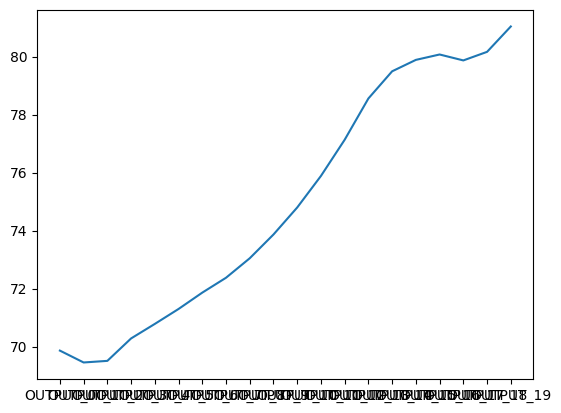

In [274]:
import matplotlib.pyplot as plt
plt.plot(synthetic_data.iloc[99,9:29])

In [272]:
preprocessor.shape_coefs

[20, 20, 34]